In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Mixup

_mixup_ can be thought of as a type of data augmentation. It was proposed in <a href="https://arxiv.org/abs/1710.09412">mixup: Beyond Empirical Risk Minimization</a> to address some basic problems of empirical risk minimization (ERM - essentially, supervised machine learning).

One of the main problems they see is that:

    ERM is unable to explain or provide generalization on testing distributions that differ only slightly from the training data. 

Our data constricts what our model is able to learn. Even with complex neural networks the parameters can learn simple decision boundaries.


To overcome these issues they propose _mixup_:

    In essence, mixup trains a neural network on convex combinations of pairs of examples and their labels. By doing so, mixup regularizes the neural network to favor simple linear behavior in-between training examples.

In [2]:
#export
from exp.nb_12 import *

__Data__

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160) # downloads and returns a path to folder
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] # transforms to be applied to images
bs = 128 # batch size
il = ImageList.from_files(path, tfms=tfms) # Imagelist from files
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name="val")) # Splitdata by grandparent folder function
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcesser()) # label the data by parent folder
data = ll.to_databunch(bs, c_in=3, c_out=10)

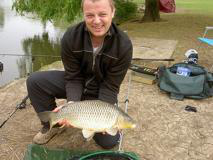

In [4]:
img1 = PIL.Image.open(ll.train.x.items[100])
img1

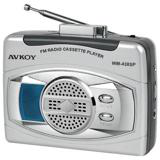

In [5]:
img2 = PIL.Image.open(il.items[2100])
img2

In [6]:
mixed_up = ll.train.x[100] * 0.3 + ll.train.x[2100] * 0.7

In [7]:
mixed_up

tensor([[[0.9388, 0.9412, 0.9541,  ..., 0.8929, 0.8929, 0.8929],
         [0.9412, 0.9471, 0.9553,  ..., 0.8953, 0.8953, 0.8953],
         [0.9412, 0.9518, 0.9553,  ..., 0.8953, 0.8953, 0.8953],
         ...,
         [0.8812, 0.8929, 0.9047,  ..., 0.9329, 0.9082, 0.9071],
         [0.8800, 0.8871, 0.8882,  ..., 0.9000, 0.9118, 0.9059],
         [0.8882, 0.8918, 0.9059,  ..., 0.9082, 0.9141, 0.8988]],

        [[0.9412, 0.9424, 0.9565,  ..., 0.9129, 0.9129, 0.9129],
         [0.9435, 0.9482, 0.9576,  ..., 0.9165, 0.9165, 0.9165],
         [0.9435, 0.9529, 0.9576,  ..., 0.9165, 0.9165, 0.9165],
         ...,
         [0.8518, 0.8635, 0.8753,  ..., 0.9059, 0.8800, 0.8788],
         [0.8518, 0.8576, 0.8600,  ..., 0.8729, 0.8835, 0.8776],
         [0.8600, 0.8635, 0.8776,  ..., 0.8812, 0.8859, 0.8706]],

        [[0.9412, 0.9471, 0.9624,  ..., 0.8188, 0.8188, 0.8188],
         [0.9435, 0.9518, 0.9635,  ..., 0.8212, 0.8212, 0.8212],
         [0.9412, 0.9529, 0.9612,  ..., 0.8200, 0.8200, 0.

In a nutshell:

    mixup constructs virtual training examples 

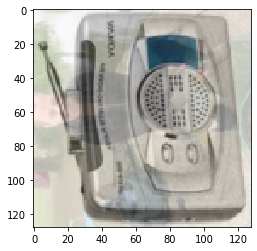

In [8]:
plt.imshow(mixed_up.permute(2,1,0))

### Implementation

The gamma function can be seen as a solution to the following interpolation problem:

Find a smooth curve that connects the points $(x,y)$ given by  $y=(x-1)!$ at the positive integer values for $x$

Basically, the gamma function using integral calculus to estimate how a smooth curve would connect the $(x,y)$ values of a factorial function. 

Pytorch has a log gamma function which we can invert to make a gamma function. 

$$ \text{out}_{i} = \log \Gamma(\text{input}_{i})$$

In [9]:
Γ = lambda x: x.lgamma().exp()

In [10]:
facts = [math.factorial(i) for i in range(7)]

In [11]:
gamma = [torch.lgamma(i).exp() for i in torch.linspace(0,6, 7)+1]

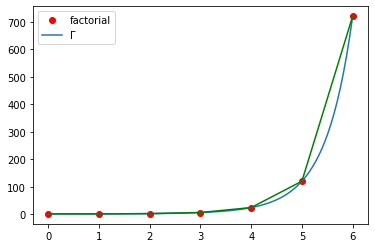

In [12]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.plot(range(7), gamma, 'g')
plt.legend(['factorial','Γ']);

<a href='https://en.wikipedia.org/wiki/Beta_distribution'>Beta Distribution </a>

This is a smoothed histogram of how we are going to sample from the probability distribution:

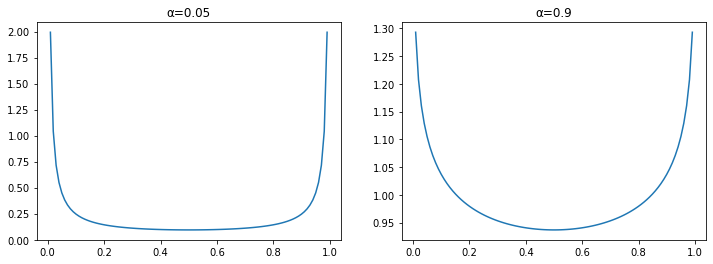

In [13]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.05,0.9], axs):
    α = tensor(α)
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

``` python
nn.CrossEntropyLoss(
    weight=None,
    size_average=None,
    ignore_index=-100,
    reduce=None,
    reduction='mean',
)```

Reduction: 

    (string, optional): Specifies the reduction to apply to the output: ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied, ``'mean'``: the sum of the output will be divided by the number of elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`

In [14]:
#export

class NoneReduce():
    def __init__(self, loss_func):
        self.loss_func = loss_func
        self.old_red = None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, "reduction")
            setattr(self.loss_func, "reduction", "none")
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
    def __exit__(self, type, value, traceback):
        if self.old_red is not None:
            setattr(self.loss_func, 'reduction', self.old_red)

Mixup

In [15]:
#export

from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss  

def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

In [16]:
#export
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [28]:
nfs = [32,64,128,256,512]

In [18]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [29]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

In [30]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [31]:
learn.fit(20)

Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.419622,0.267610,2.003884,0.324076,00:49
1,1.982678,0.422220,1.704136,0.424968,00:14
2,1.774361,0.503221,1.596484,0.467006,00:14
3,1.602577,0.581265,1.502526,0.529427,00:14
4,1.475780,0.640406,1.448558,0.538089,00:14
5,1.354006,0.704193,1.448375,0.532994,00:14
6,1.246474,0.762066,1.389561,0.565860,00:14
7,1.176728,0.803675,1.386392,0.563567,00:14
8,1.120573,0.831344,1.393681,0.559236,00:14
9,1.072697,0.858697,1.433798,0.550573,00:14


Let's change the mixup alpha parameter:

In [34]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        partial(MixUp, α=0.8)]

In [35]:
learn = get_learner(nfs, data, 0.3, conv_layer, cb_funcs=cbfs)

In [36]:
learn.fit(20)

Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.243384,0.286831,1.991623,0.365096,00:14
1,1.989007,0.410709,1.719718,0.429554,00:14
2,1.851590,0.470377,1.516430,0.495796,00:14
3,1.746321,0.531630,1.525054,0.508280,00:14
4,1.653273,0.583694,1.374568,0.553885,00:14
5,1.579662,0.636076,1.403818,0.558981,00:14
6,1.512453,0.674728,1.360479,0.559490,00:14
7,1.450433,0.707044,1.396608,0.555669,00:14
8,1.395506,0.745485,1.394769,0.553885,00:14
9,1.354163,0.774844,1.349654,0.563567,00:14


In [22]:
nb_auto_export()

<IPython.core.display.Javascript object>